In [2]:
import anndata as ad
import episcanpy.api as epi
import scanpy as sc
import numpy as np
import time

In [3]:
import episcanpy
print(episcanpy.__version__)

0.1.7+20.g60484de


In [4]:
# define data directory
DATADIR = './data/'

In [5]:
# To load the peak matrix
adata = ad.read(DATADIR+'GSM3034622_BoneMarrow_62016_GSM3034623_BoneMarrow_62216_peakmatrix.h5ad')
adata

AnnData object with n_obs × n_vars = 12906 × 436206 
    obs: 'batch', 'cell', 'cell_label\n', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2'

In [6]:
# format cell label metadata
adata.obs['cell_label'] =[n.rstrip('\n') for n in adata.obs['cell_label\n']]
del adata.obs['cell_label\n']

In [7]:
# settings for the plots
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=250,
                     frameon=True, vector_friendly=True,
                     color_map="YlGnBu", format='pdf', transparent=False,
                     ipython_format='png2x')


result_file = 'GSM3034622_BoneMarrow_62016_GSM3034623_BoneMarrow_62216_peakmatrix_processed.h5ad'

# Quality controls

In [8]:
# preliminary filtering
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)

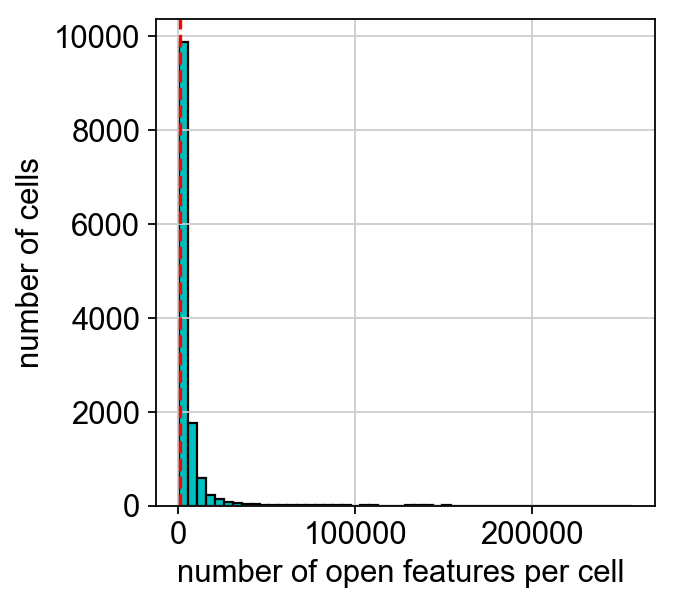

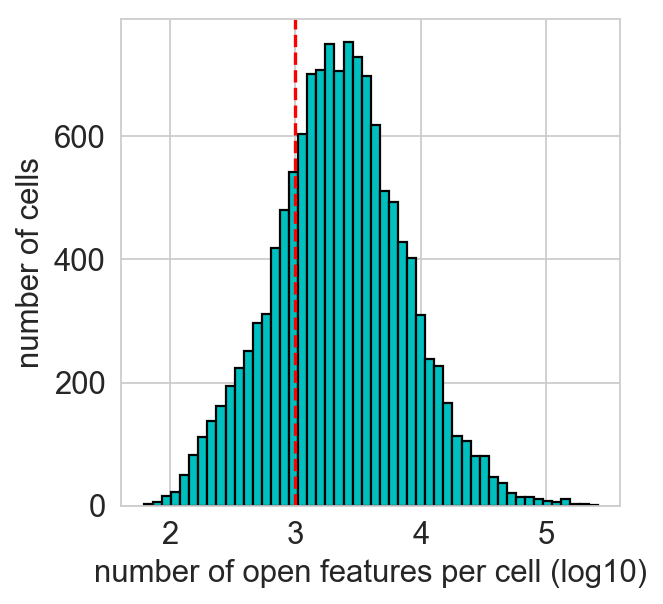

In [9]:
epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=1000, save='coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=1000, save='coverage_cells.png')

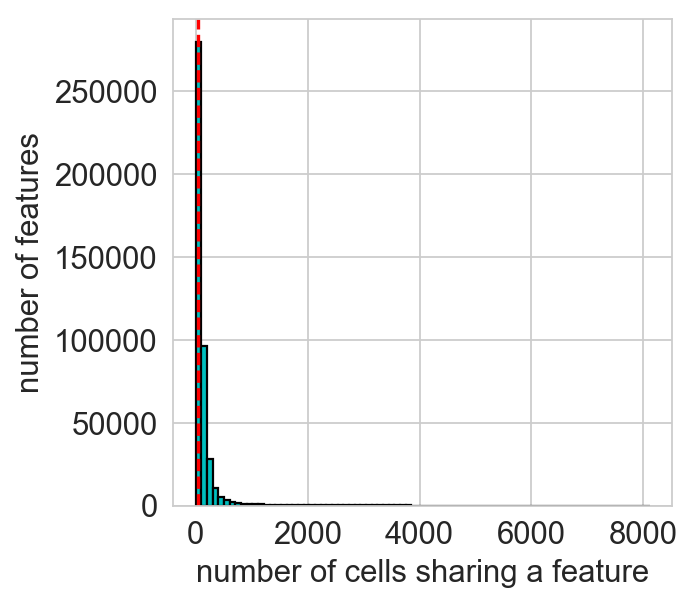

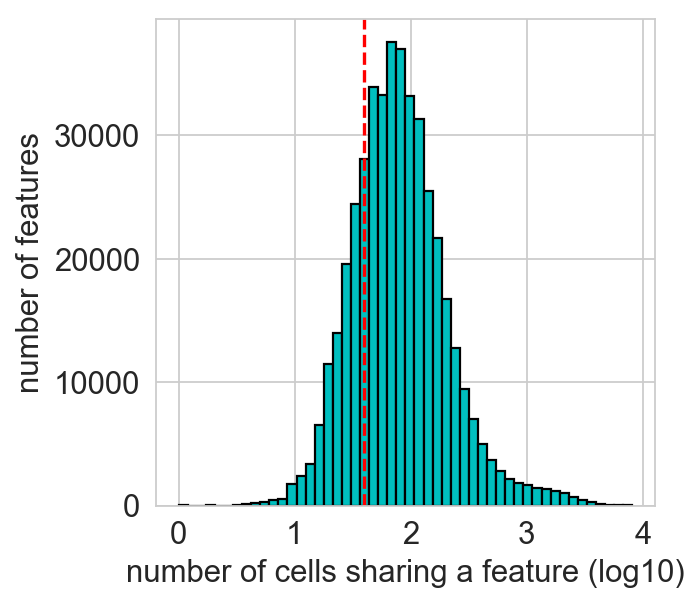

In [10]:
epi.pp.coverage_features(adata, binary=True, log=False, bins=50,
               threshold=40, save='coverage_cells.png')
epi.pp.coverage_features(adata, binary=True, log=10, bins=50,
               threshold=40, save='coverage_cells.png')

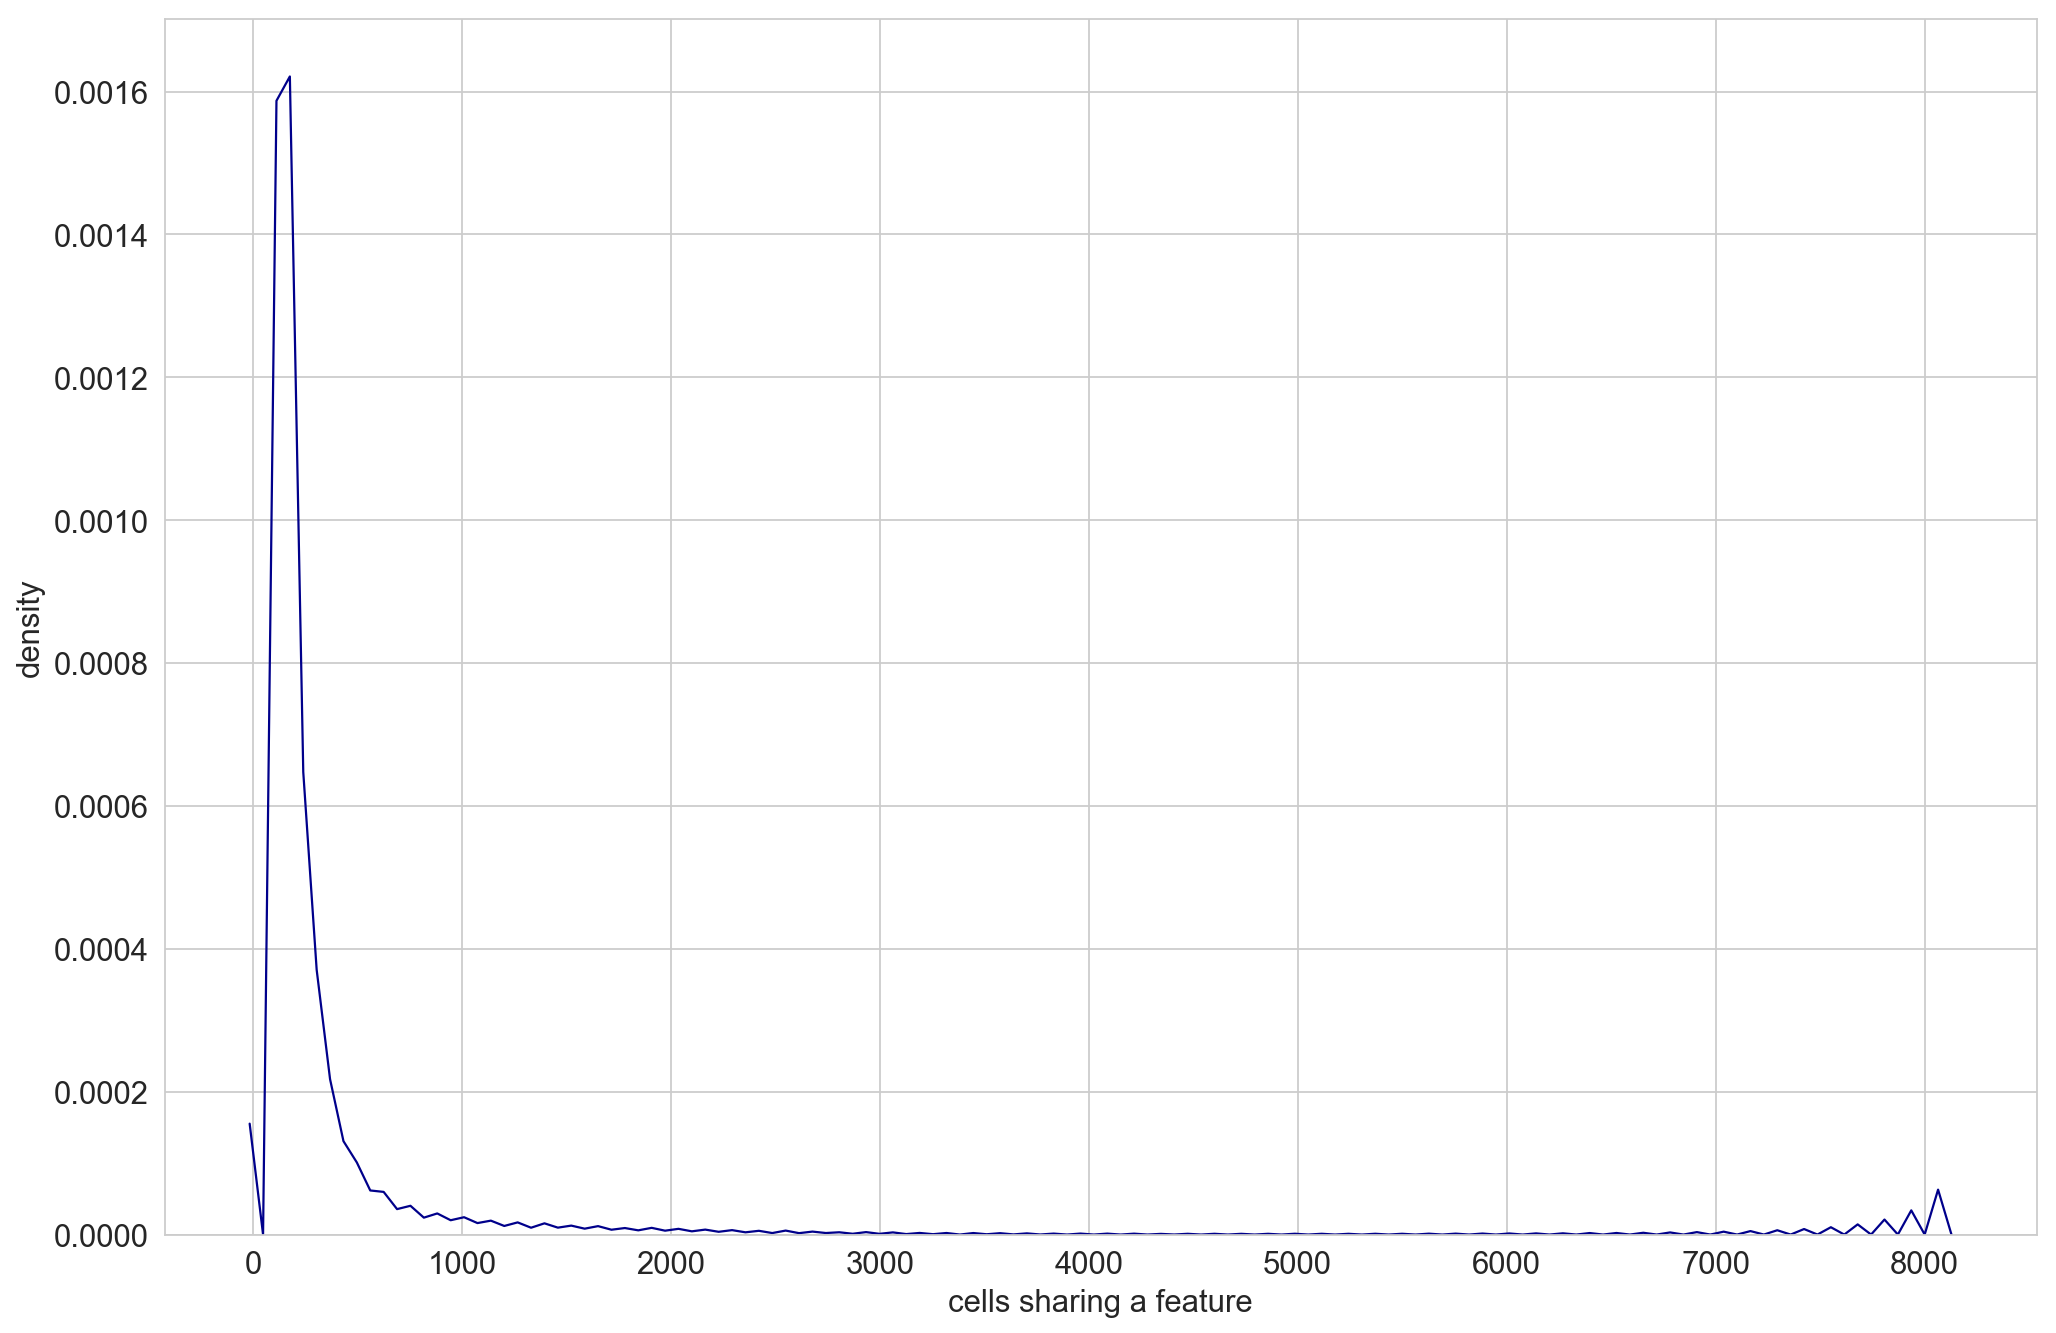

In [11]:
epi.pp.density_features(adata)

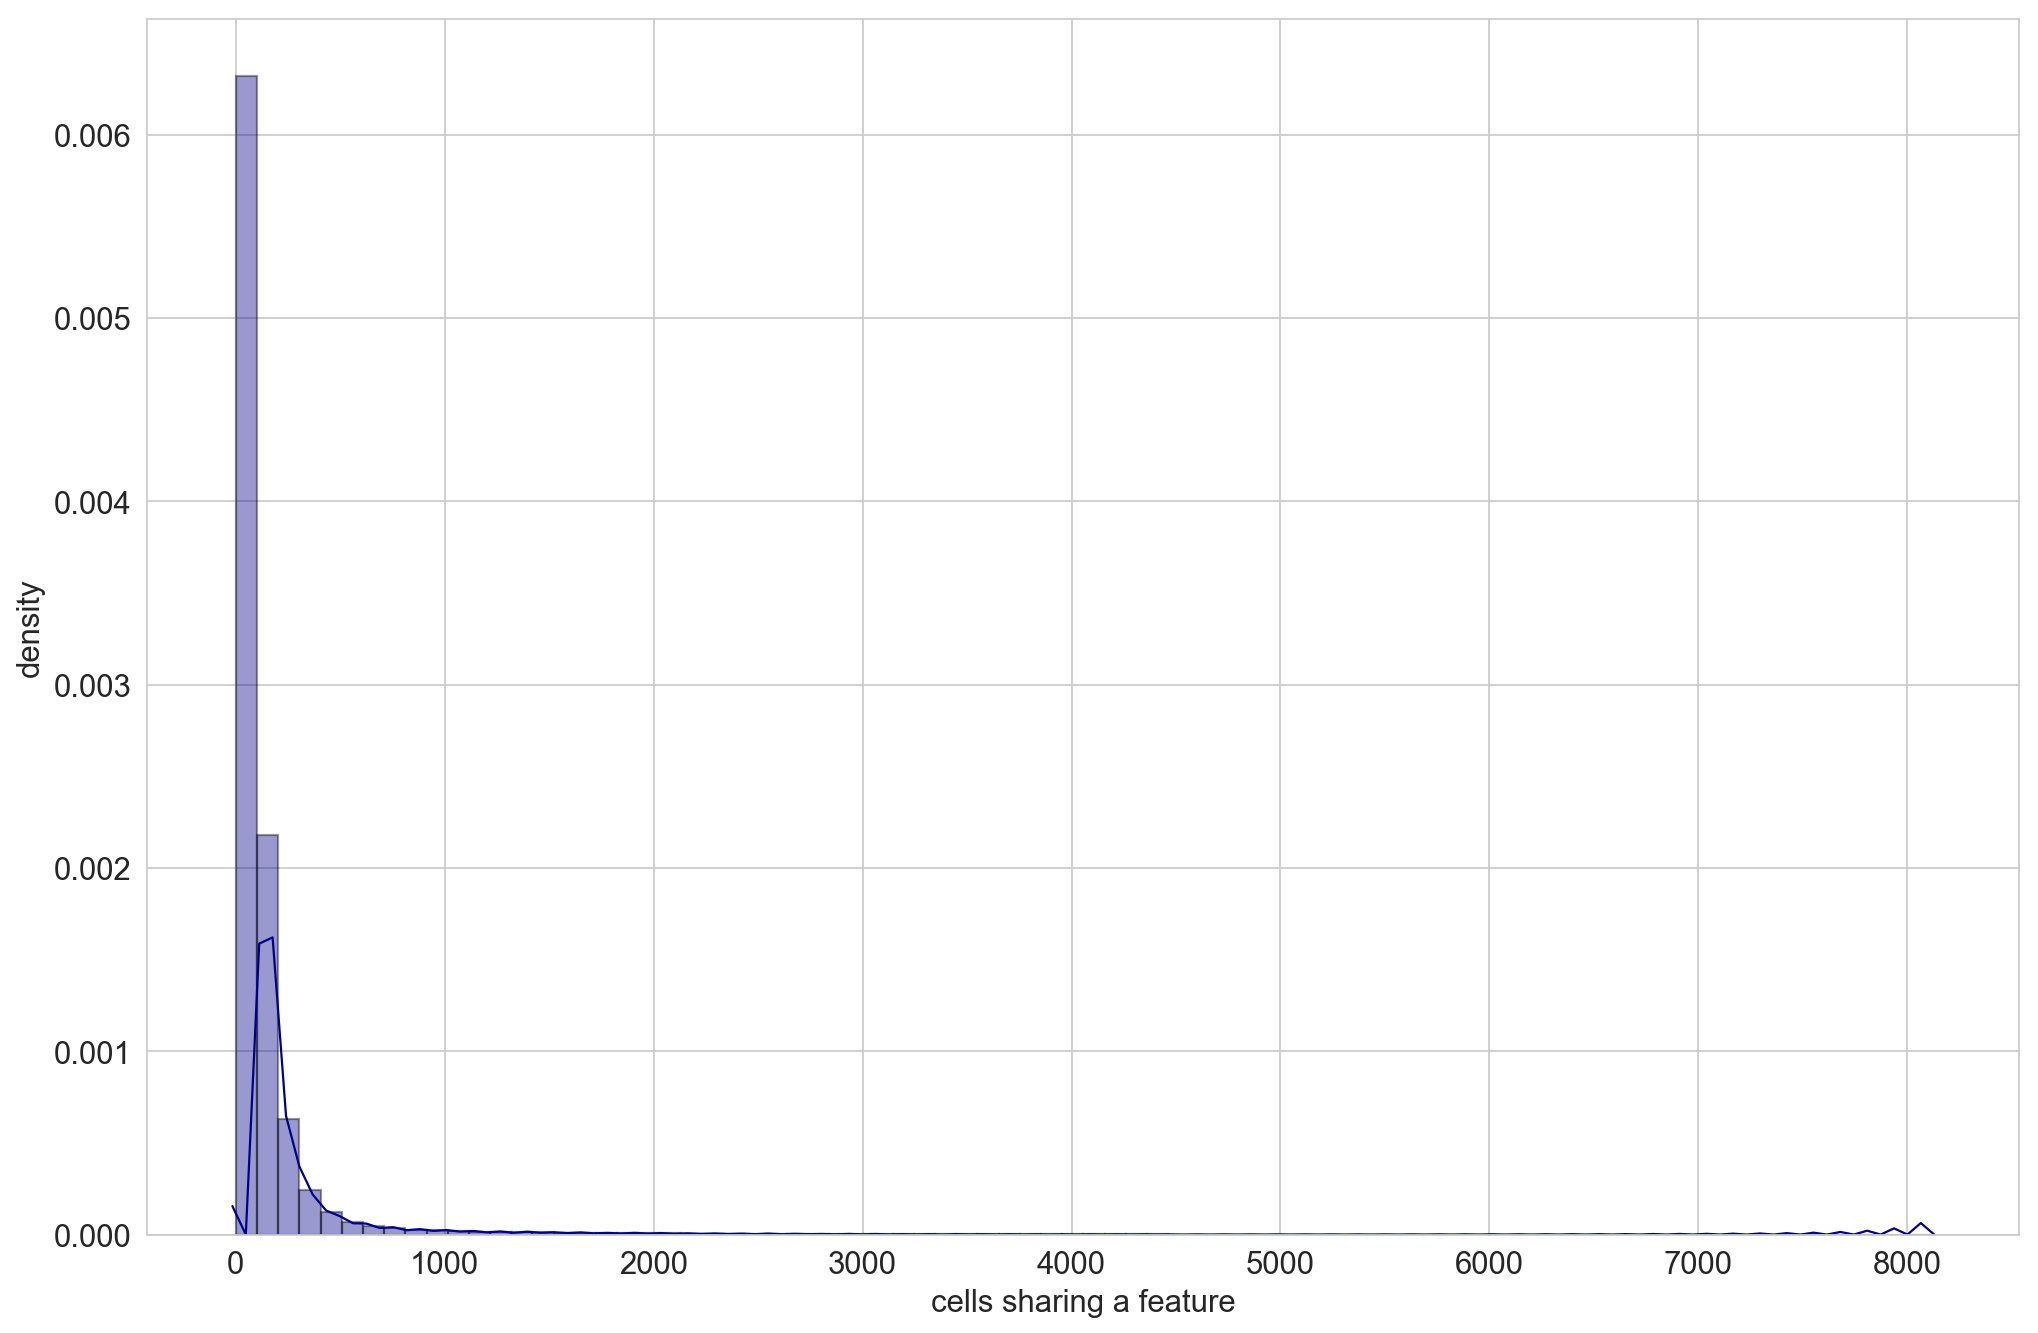

In [12]:
epi.pp.density_features(adata, hist=True)

### Actually filtering the cells

In [13]:
epi.pp.filter_cells(adata, min_features=1000)

In [14]:
epi.pp.filter_features(adata, min_cells=40)

#### Looking at the QC plots after filtering

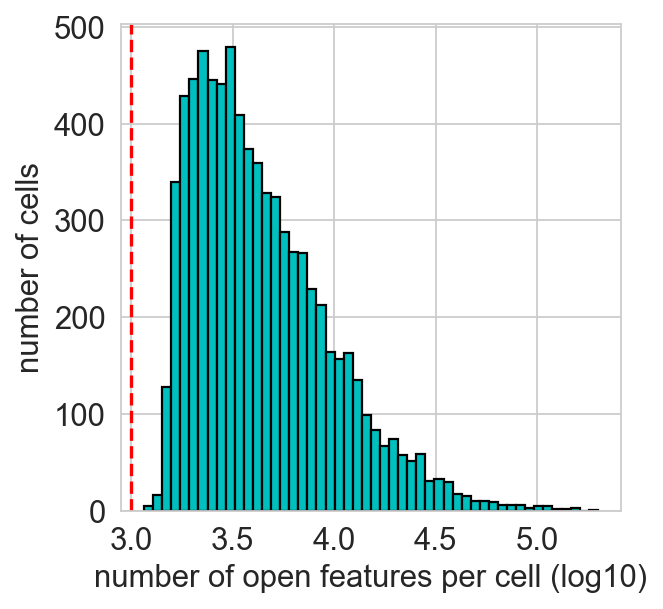

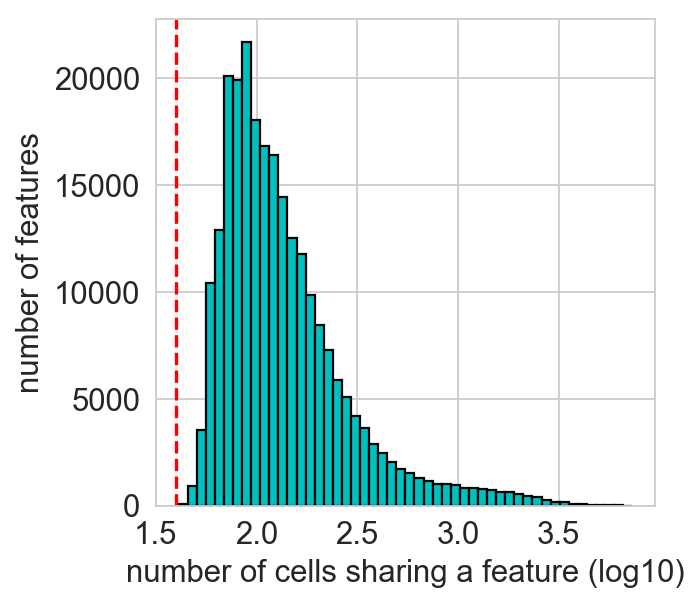

In [15]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=1000)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=40)

### Identifying the most variable features

In [16]:
adata

AnnData object with n_obs × n_vars = 7563 × 246595 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features'
    var: 'n_cells', 'commonness'

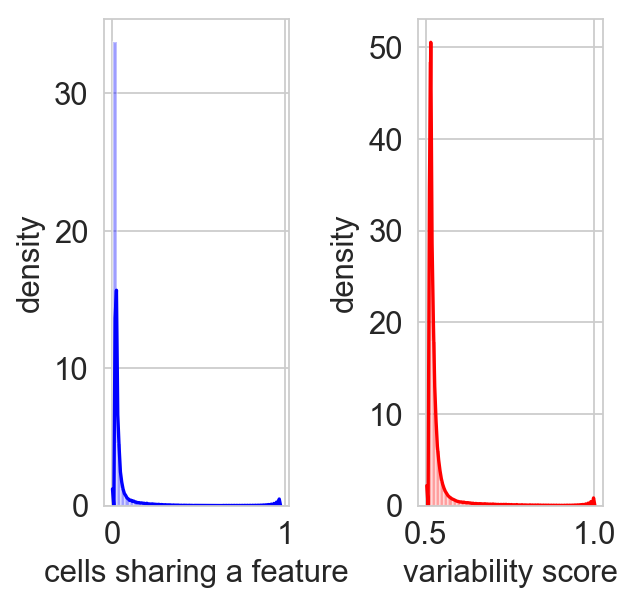

In [17]:
epi.pp.cal_var(adata)

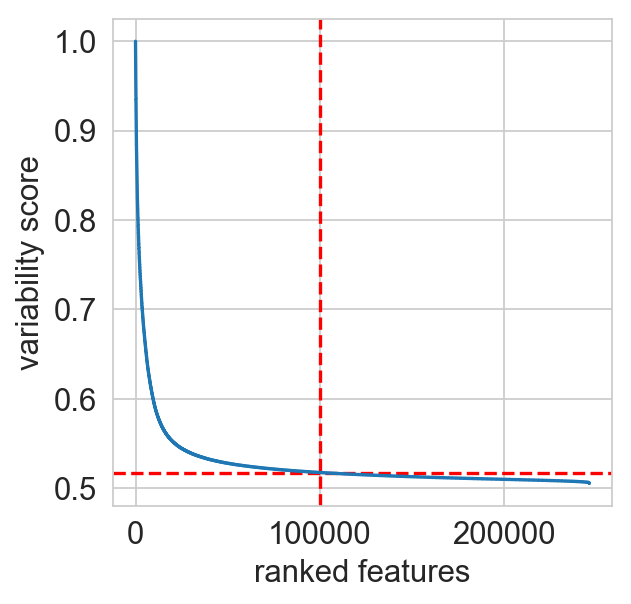

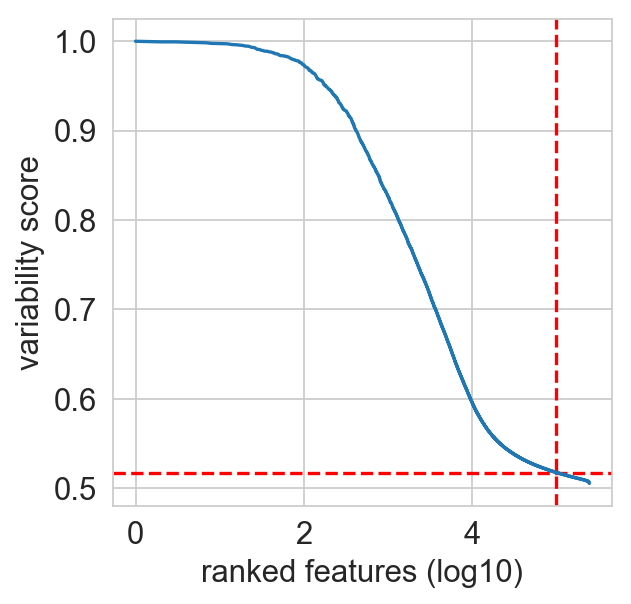

In [18]:
min_score_value = 0.517
nb_feature_selected = 100000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_bonemarrow_peakmatrix_log10.png')

In [19]:
# save the current matrix in the raw layer
adata.raw = adata

In [20]:
# create a new AnnData w=containing only the most variable features
adata2 = epi.pp.select_var_feature(adata,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [21]:
adata2

View of AnnData object with n_obs × n_vars = 7563 × 100172 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

### Normalisation (correct library size)

In [22]:
epi.pp.normalize_per_cell(adata2)
epi.pp.log1p(adata2)

Trying to set attribute `.obs` of view, making a copy.


In [23]:
# save intermediary file
adata2.write(result_file)

... storing 'cell_label' as categorical


correlation: 0.1305271651612115
pval: 4.264692246254009e-30


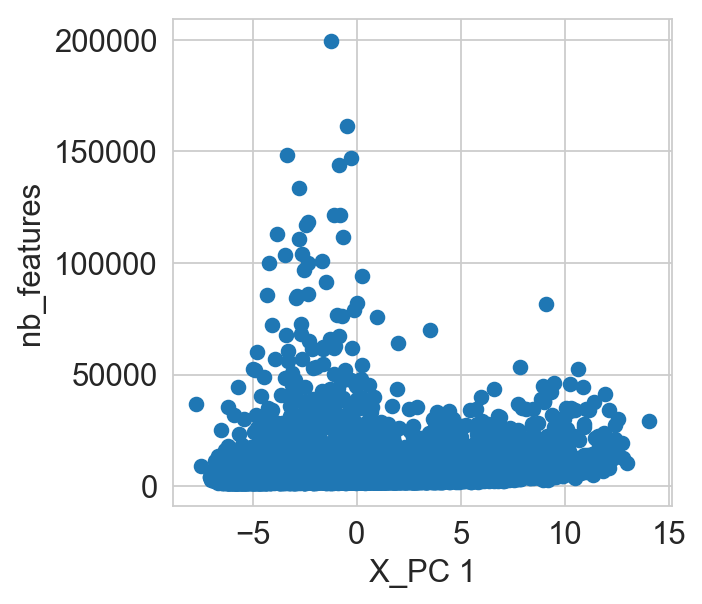

In [31]:
#Check if the coverage is a covariate to correct. Here is it is not the case anymore (post library size normalisation)
epi.pp.correlation_pc(adata2, 'nb_features')

### Principal Component Analysis

In [39]:
epi.pp.pca(adata2, n_comps=100)

In [ ]:
epi.pl.pca_overview(adata2)
sc.pl.pca(adata2, color=['nb_features', 'batch'], wspace=0.5)

### Neighboring graph and UMAP

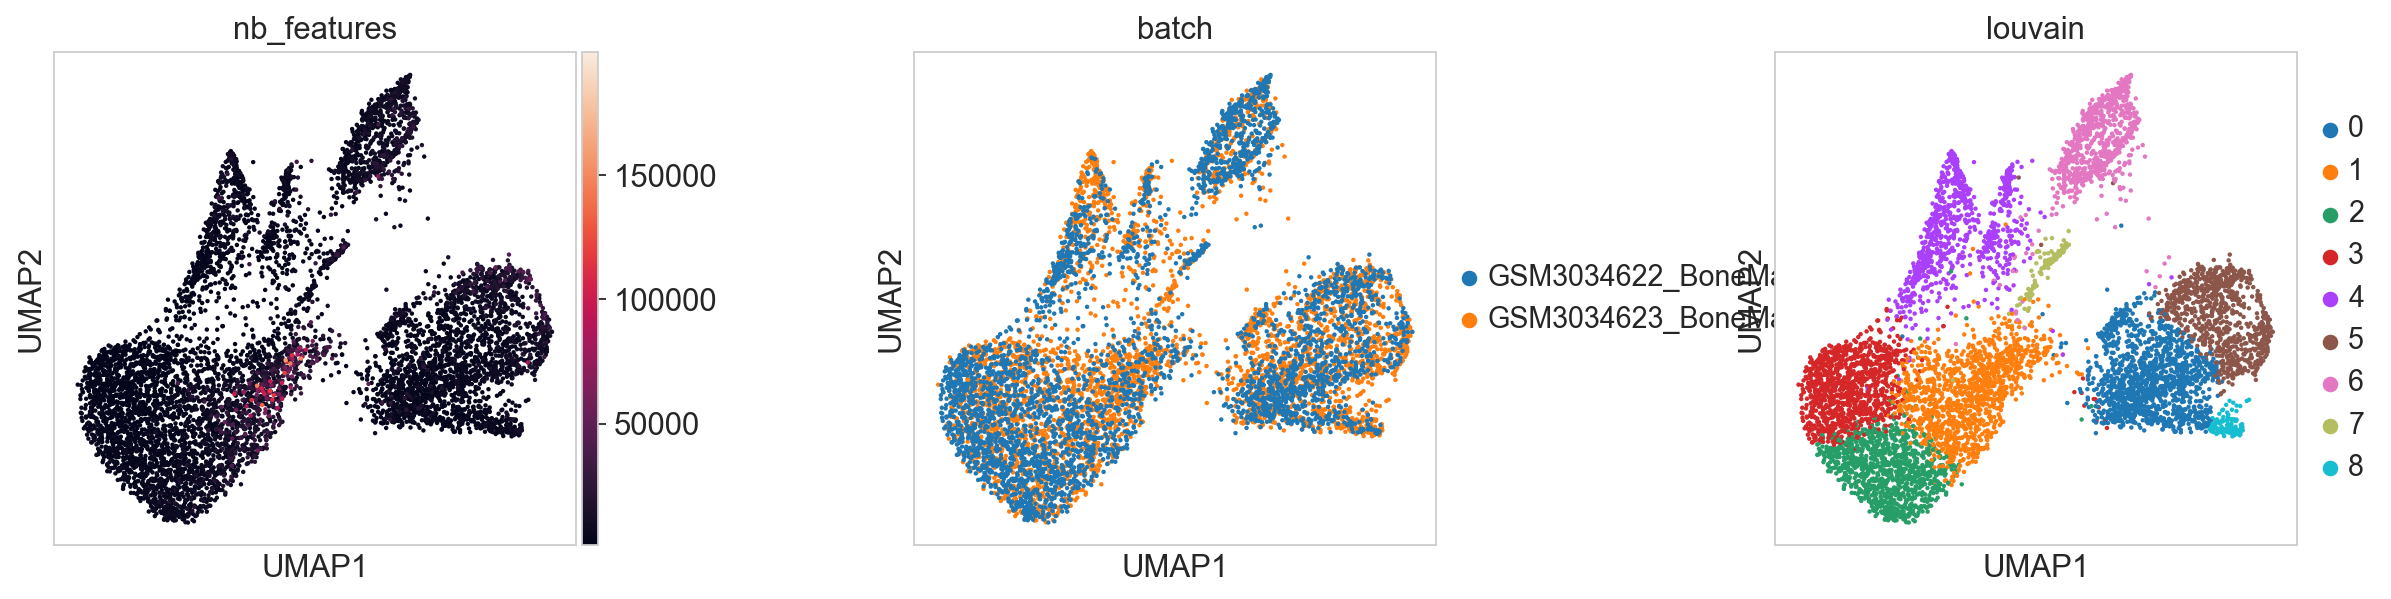

In [65]:
epi.pp.neighbors(adata2, n_neighbors=15, n_pcs=100, method='gauss')
epi.tl.umap(adata2, min_dist=0.5,spread=1, a=1,b=1)
epi.tl.louvain(adata2)
sc.pl.umap(adata2, color=['nb_features', 'batch', 'louvain'], wspace=0.5)

In [ ]:
# calculate a second louvain clustering with a lower resolution
epi.tl.louvain(adata, resolution=0.5, key_added='louvain_lowres')

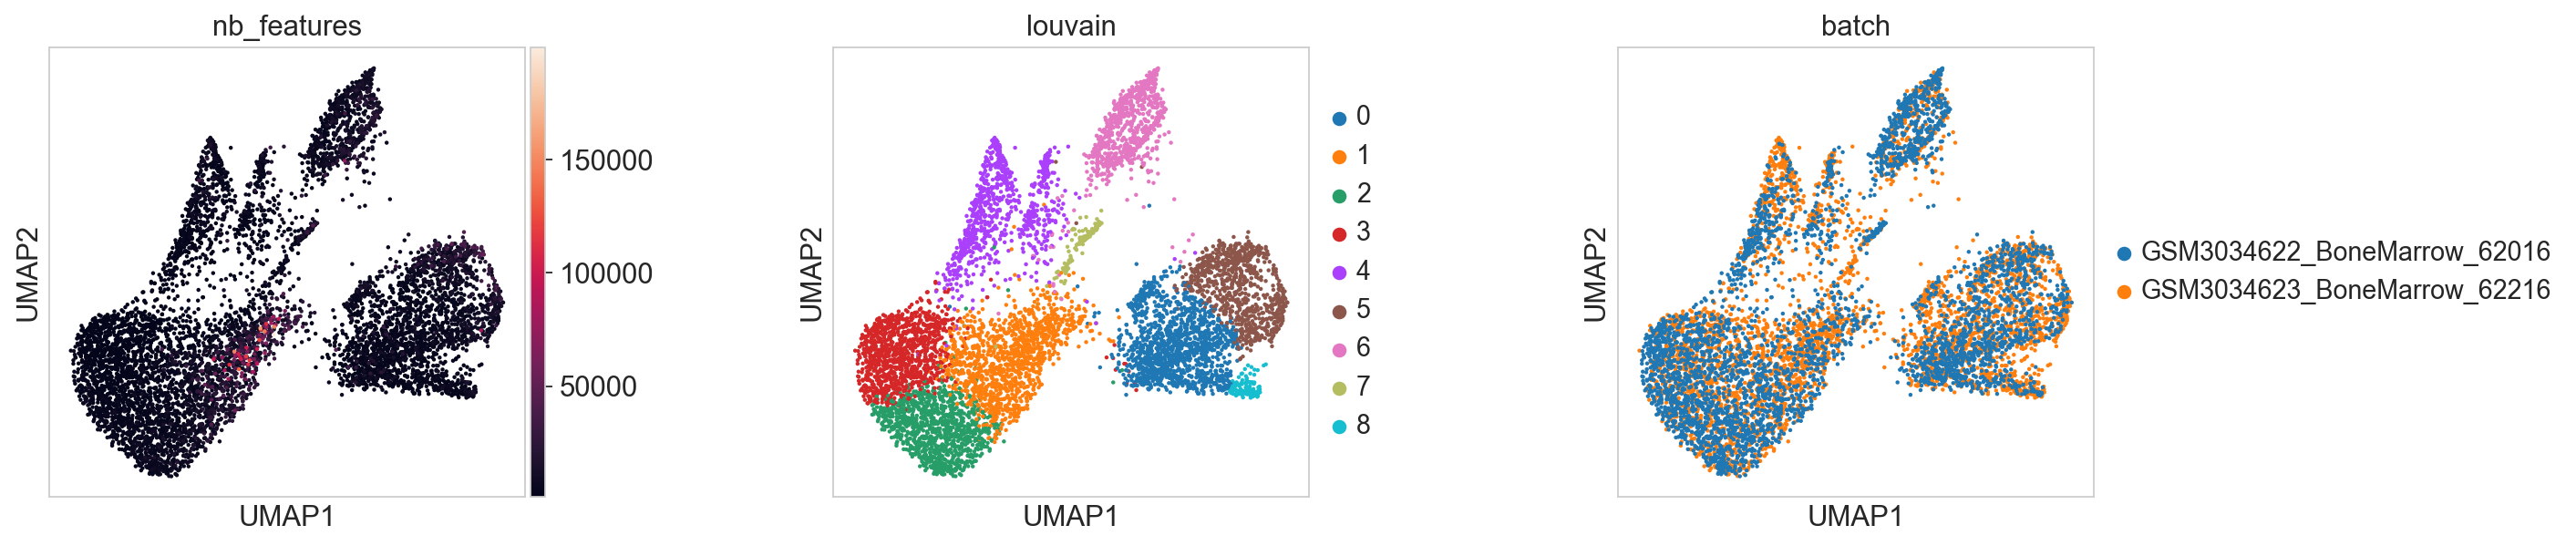

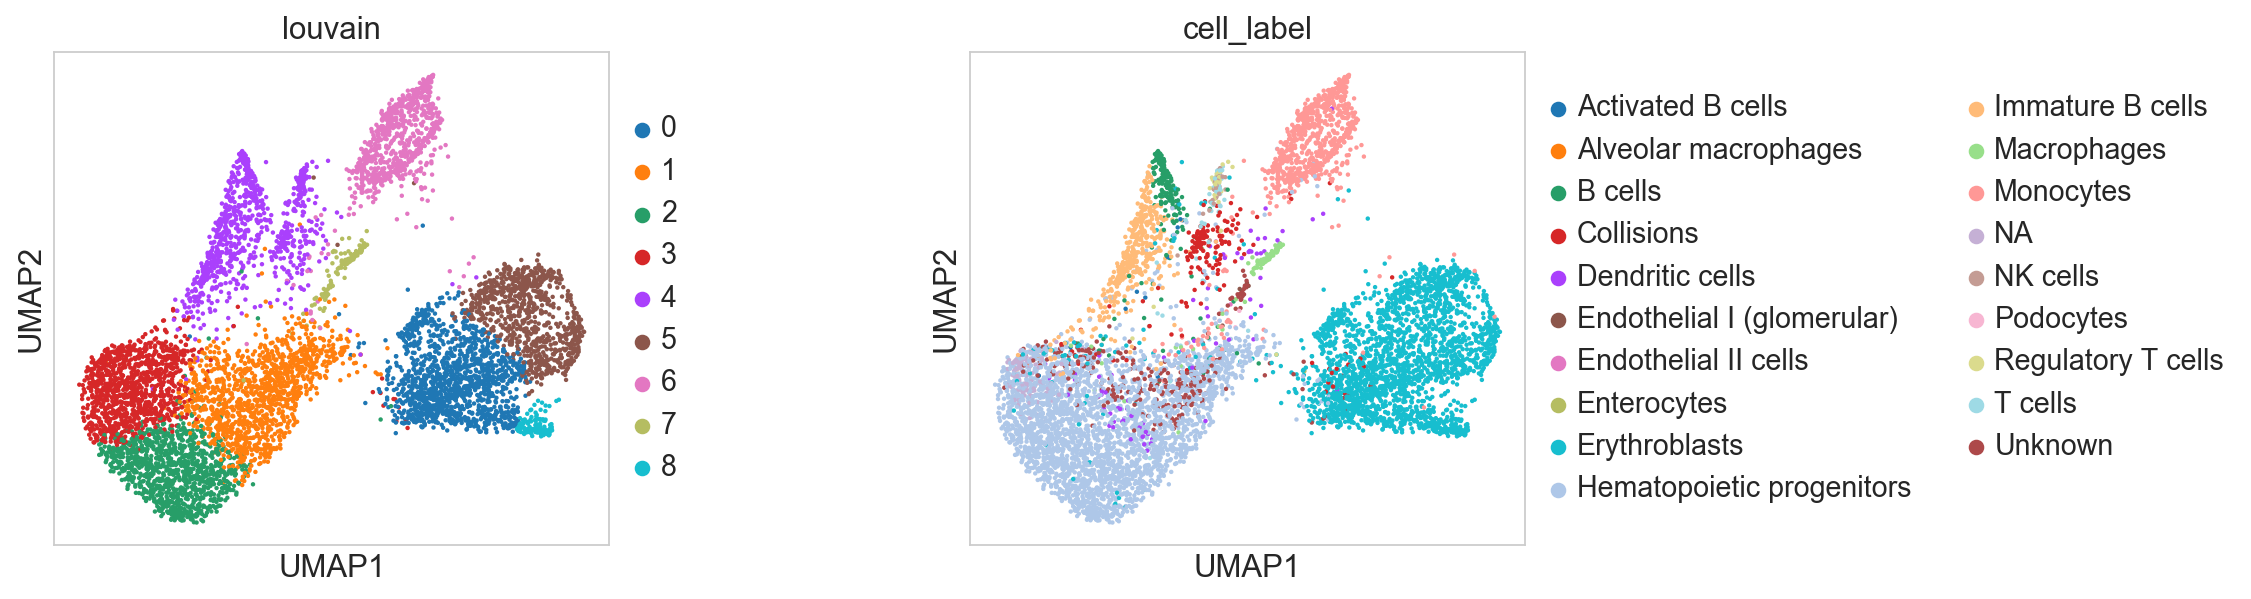

In [69]:
sc.pl.umap(adata2, color=['nb_features', 'louvain', 'batch'], wspace=0.5)
sc.pl.umap(adata2, color=['louvain', 'louvain_lowres', 'cell_label'], wspace=0.5)

### Diffusion Map

In [73]:
epi.tl.diffmap(adata2)

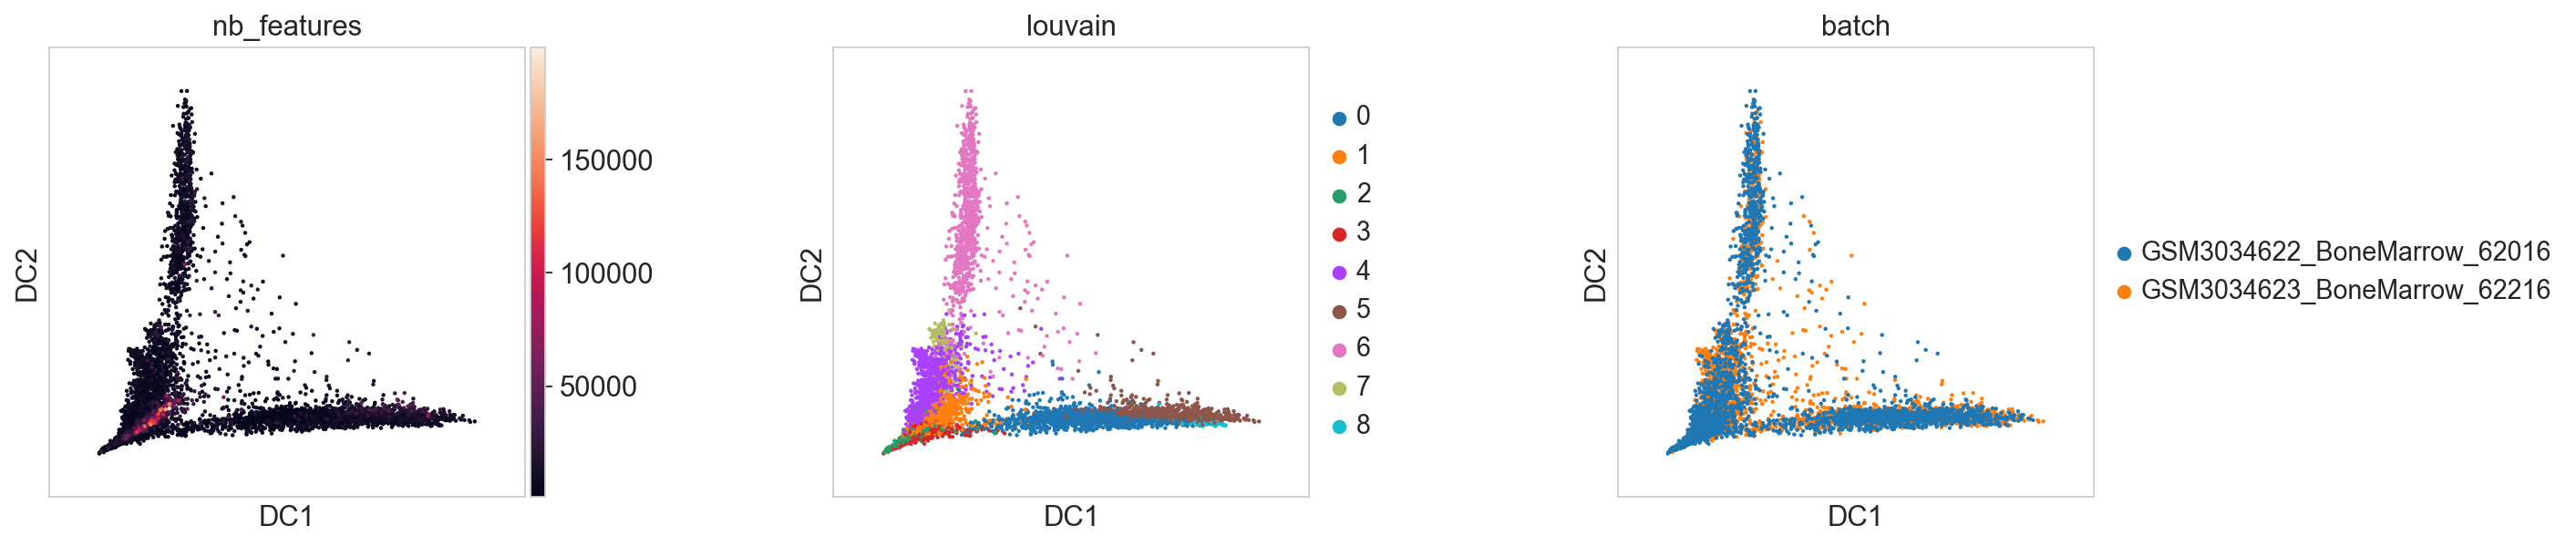

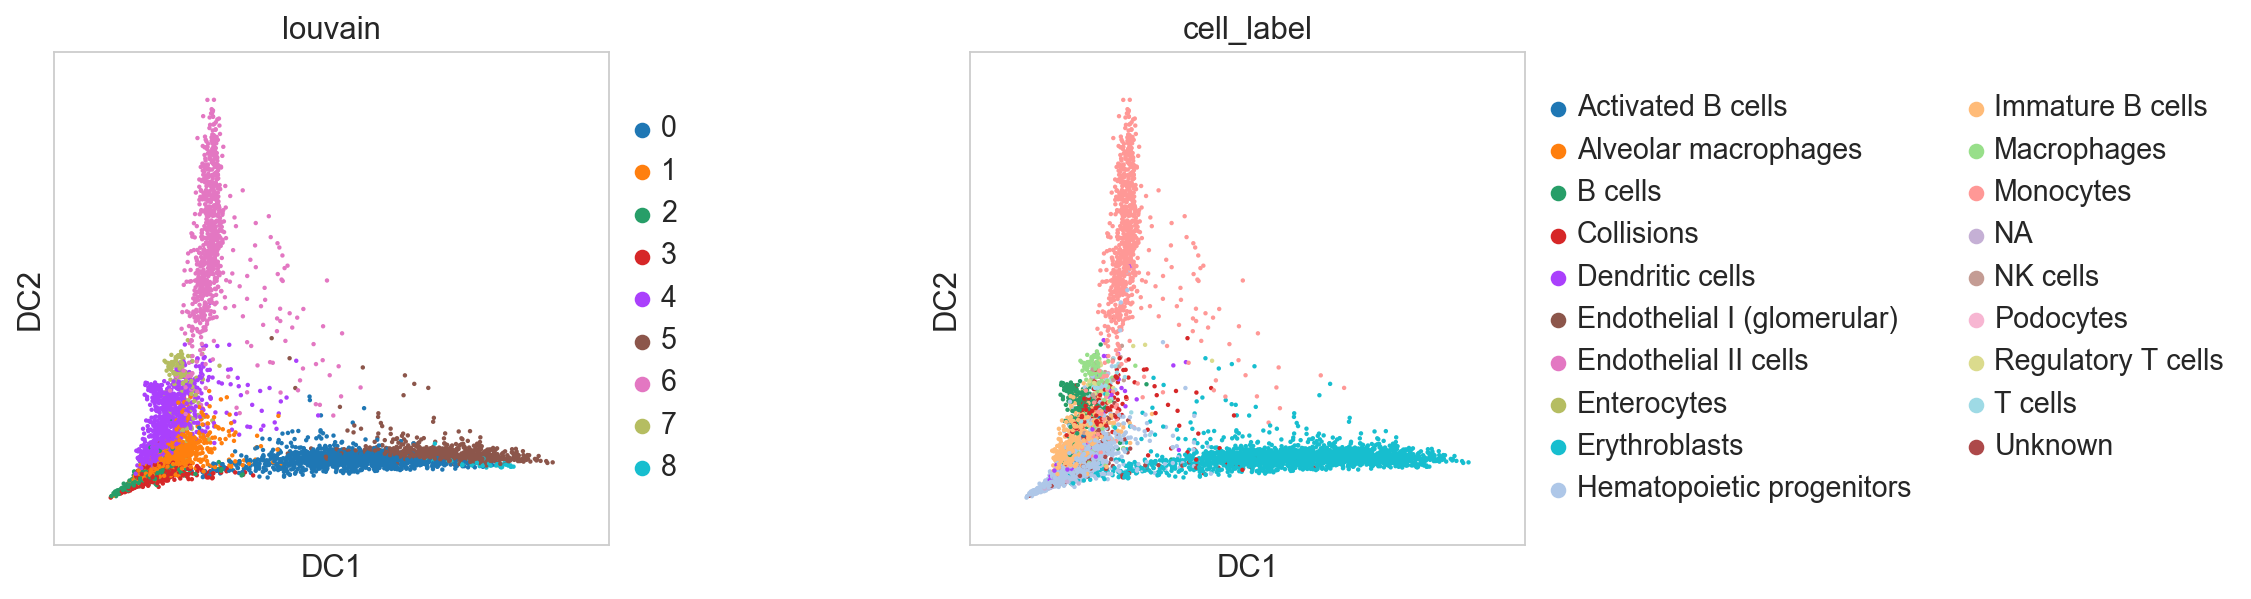

In [75]:
sc.pl.diffmap(adata2, color=['nb_features', 'louvain', 'batch'], wspace=0.5)
sc.pl.diffmap(adata2, color=['louvain', 'louvain_lowres', 'cell_label'], wspace=0.5)

### Diffusion pseudotime

In [76]:
# Root for the dpt
adata2.uns['iroot'] = np.flatnonzero(adata2.obs['louvain']  == '2')[0]
# calculate the dpt
epi.tl.dpt(adata2)

In [77]:
adata2

AnnData object with n_obs × n_vars = 7563 × 100172 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features', 'n_counts', 'louvain', 'dpt_pseudotime'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'batch_colors', 'correlation_pc', 'louvain', 'louvain_colors', 'cell_label_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_diffmap'
    varm: 'PCs'

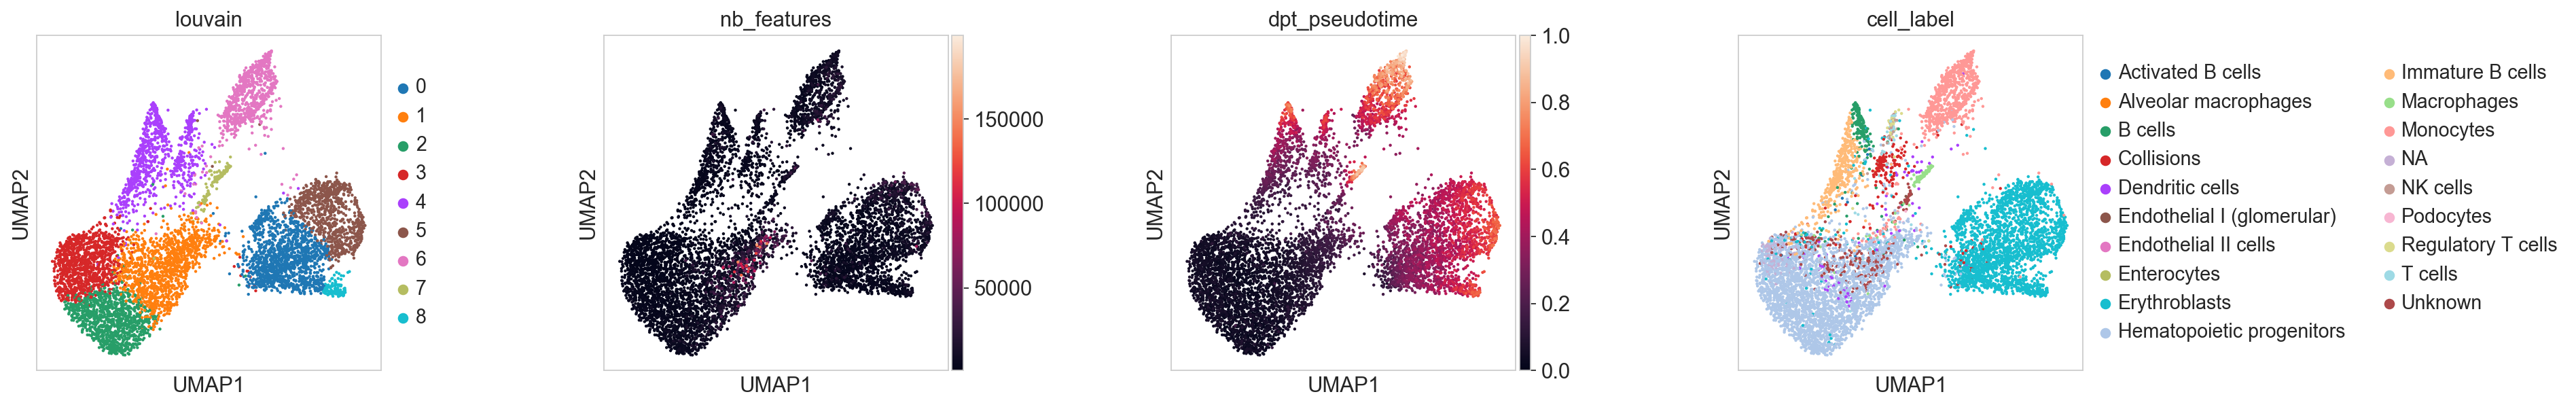

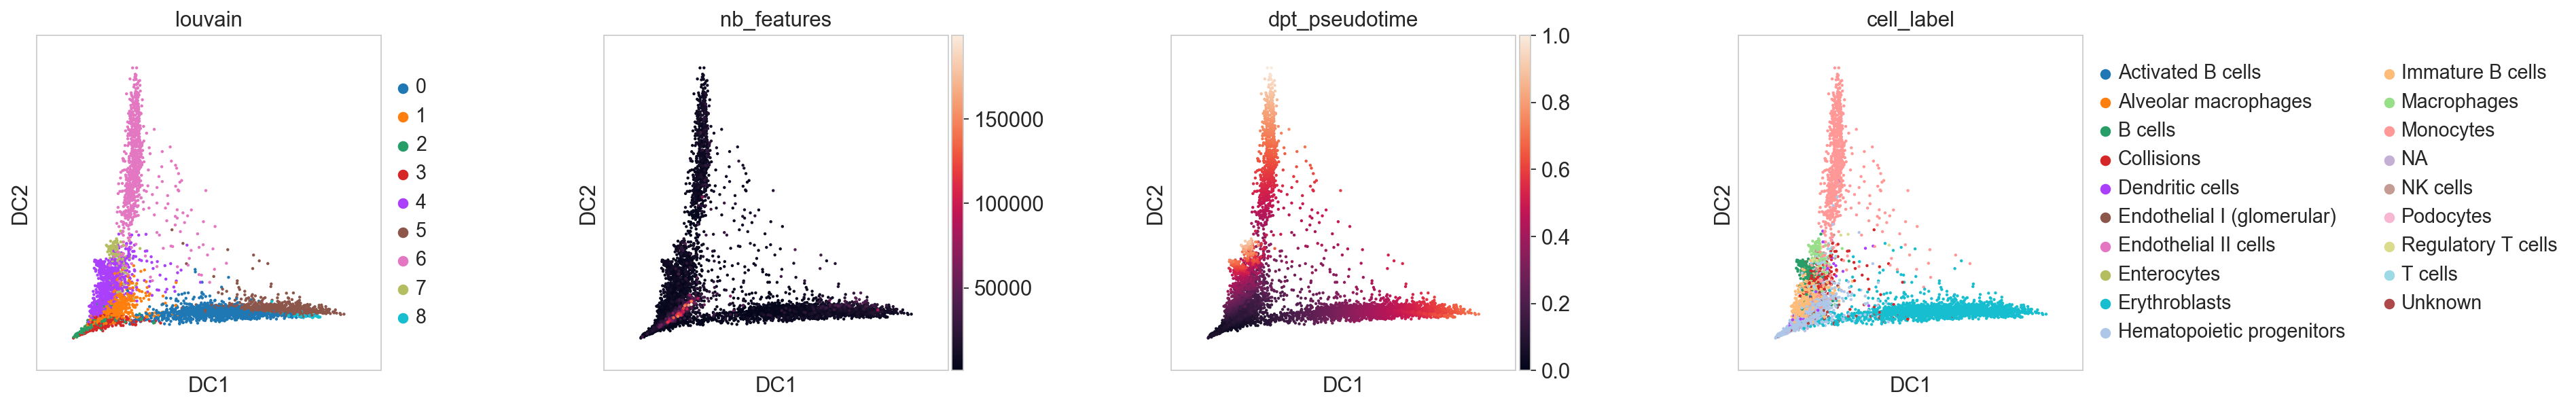

In [79]:
sc.pl.umap(adata2, color=['louvain','nb_features', 'dpt_pseudotime', 'cell_label'], wspace=0.5)
sc.pl.diffmap(adata2, color=['louvain','nb_features', 'dpt_pseudotime', 'cell_label'], wspace=0.5)

In [80]:
adata2

AnnData object with n_obs × n_vars = 7563 × 100172 
    obs: 'batch', 'cell', 'cluster', 'id', 'subset_cluster', 'subset_tsne1', 'subset_tsne2', 'tissue', 'tissue.replicate', 'tsne_1', 'tsne_2', 'cell_label', 'nb_features', 'n_counts', 'louvain', 'dpt_pseudotime'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'pca', 'neighbors', 'batch_colors', 'correlation_pc', 'louvain', 'louvain_colors', 'cell_label_colors', 'diffmap_evals', 'iroot'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_diffmap'
    varm: 'PCs'